#  Lunar Lander with Least Squares Policy Iteration (LSPI) :

Author: Nirav Lad

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is [LSPI](https://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf) with a some differences as noted (e.g. weight updates) from the paper by [Lagoudakis](https://scholar.google.com/citations?user=VqHiIg8AAAAJ) and [Parr](https://scholar.google.com/citations?user=b-GJ3QIAAAAJ).

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats

import gymnasium as gym

from typing import List, Tuple, Union
from numpy.typing import NDArray
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from gymnasium.wrappers import RecordVideo
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
from IPython.display import Video
import os
import shutil

## Define parameters

### Enviroment variables

In [2]:
ENV_NAME = 'LunarLander-v3'

In [3]:
env = gym.make(ENV_NAME)
cardS = len( env.observation_space.low )
A = np.arange( env.action_space.n )
env.close()

num_best_policies = 10

### Hyperparameters

In [4]:
Δ = 1e-6
γ = 0.9
lr = (0.5, 0.5, 0.01)

## Functions

### Mean and halfwidth calculation

In [5]:
def calculate_mean_hw( d: Union[List[np.float32] | NDArray[np.float32]], ci:int = 0.95 ) -> Tuple[np.float32, np.float32]:
    d = np.array( d )
    n = np.size( d )
    std_error = np.std( d, ddof=1 ) / np.sqrt(n)
    t_critical = stats.t.ppf( 1 - ( 1 - ci ) / 2, n - 1 )
    mean = np.mean( d ) 
    halfwidth = t_critical * std_error
    return( mean, halfwidth )

### Basis functions

Each row of $\Phi$ contains the value of all basis functions for a certain pair $(s,a)$ and each
column of $\Phi$ contains the value of a certain basis function for all pairs $(s,a)$. Using the indicator function $I$ then we have $\Phi(s,a) = \begin{pmatrix} x(s)\times I(a=1), \cdots, x(s)\times I(a=k)\end{pmatrix}^{\intercal}$

In [6]:
def x( state:NDArray[np.float32] ) -> NDArray[np.float32]:

    px, py, vx, vy, θ, ω, lf, rf = state

    interactions = np.array([px*py, px*vx, px*θ, px*ω, px*lf, px*rf,
                             py*vx, py*vy, py*θ, py*ω, py*lf, py*rf,
                             vx*vy, vx*θ, vx*ω, vx*lf, vx*rf,
                             vy*θ, vy*ω, vy*lf, vy*rf,
                             θ*ω, θ*lf, θ*rf,
                             θ*lf, θ*rf,
                             lf*rf])
    
    return( np.hstack( ( state, interactions ) ) )

In [7]:
def Φ( state:NDArray[np.float32] = None, action:int = None ) -> NDArray[np.float32]:
    return( np.hstack([ x(state ) * ( a == action ) for a in A ]) )

### Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \Phi(s,a)^{\intercal} w$

In [8]:
def π( state:NDArray[np.float32], w:NDArray[np.float32] ) -> int:
    return( np.argmax( [ np.dot( Φ( state, a ), w ) for a in A ]) )

### TD Learning rate

The learning rate at episode $n$ with initial learnign rate $\alpha_a$ and learning rate decay $\alpha_b$ is defined as $\alpha_n =  a_{a}\left( \frac{1}{(1 + n)^{\alpha_{b}}} \right)$

In [9]:
def α( n:int, lr:Tuple[int,int] = (0.5, 0.5) ):
    α_init, α_decay, α_min = lr
    return( np.maximum( α_init / (n + 1)**α_decay, α_min ) )

### Generate random samples

In [10]:
def get_samples( w:NDArray[np.float32], num_samples:int = int(2**7), max_samples:int = int(2**11), seed:int = 42, enable_wind:bool = False ) -> List[Tuple]:

    env = gym.make( ENV_NAME, enable_wind = enable_wind )

    np.random.seed( int( seed * 1e3 ) )

    samples = []

    while ( len(samples) <  max_samples ):

        terminated = False
        truncated = False

        s = env.reset( seed = int( seed * 1e3 ) )[0]

        while not( terminated or truncated ):
            a = π( s, w )  
            sP, r, terminated, truncated, _ = env.step( a )
            samples.append( (s, a, r, sP, terminated) )
            s = sP
            if ( len(samples) == max_samples ):
                break

    env.close()

    indicies = np.random.choice( len(samples), size=num_samples, replace=False )
    random_samples = [ samples[i] for i in indicies ]

    return( random_samples )

### Evaluate policy

In [11]:
def evaluate_policy( w:NDArray[np.float32], num_evaluations:int = 5, seed:int = 42, enable_wind:bool = False ): 

    env = gym.make( ENV_NAME, enable_wind = enable_wind )

    G = []

    for n in np.arange( num_evaluations ):
        terminated = False
        truncated = False

        Gm = 0
        s = env.reset( seed = int( seed * 1e2 + n * 3e4 ) )[0]

        while not( terminated or truncated ):
            a = π( s, w )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r

        G.append( Gm )

    μ, δ = calculate_mean_hw( G )

    return ( μ, δ )

### **LSTDQ**-opt

Implementation of <b>LSDQ</b>-opt that utilizes the [Sherman-Morris formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) to compute the "rank-1 update" for matrix inversion. This allows computation in $O(n^2)$ as opposed to $O(n^3)$.

<b>Inputs</b>:
- $D$: Source of samples $(s,a,r,s')$
- $k$: Number of basis functions
- $\Phi$: Basis functions
- $\gamma$: Discount factor
- $\pi$: Policy whose value function is sought

<b>algorithm</b>:<br>
1: $\mathbf{B} \gets \frac{1}{\Delta} \mathbf{I} \;\;$ is a $(k \times k)$ matrix<br>
2: $b \gets \mathbf{0} \;\;$ is a $(k \times 1)$ matrix<br>
3: <b>for each</b> $(s,a,r,s') \in D$<br>
4: &nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{B} \gets \mathbf{B} - \frac{ \mathbf{B}\Phi(s,a)\left( \Phi(s,a) - \gamma \Phi(s', \pi(s')) \right)^{\intercal} \mathbf{B} }{ 1 + \left( \Phi(s,a) - \gamma \Phi(s',\pi(s')) \right)^5: {\intercal} \mathbf{B} \Phi(s,a)}$<br>
5: &nbsp;&nbsp;&nbsp;&nbsp;$b \gets b + \Phi(s,a)r$<br>
6: $\tilde{w}^{\pi} \gets \mathbf{B}b$ results in a $(k \times 1)$ matrix<br>
7: <b>return<b> $\tilde{w}^{\pi}$

In [12]:
def LSTDQ_opt( D:List[Tuple], k:int, w:NDArray[np.float32], n:int, lr:Tuple[int,int] ) -> NDArray[np.float32]:

    B = np.eye( k ) * Δ
    b = np.zeros( k )

    for ( s, a, r, sP, terminated ) in D:

        Φ_sa = Φ( s, a ).flatten()
        Φ_sPaP = Φ( sP, π( sP, w )).flatten() * ( 1 - terminated ) 
        
        u = B @ Φ_sa
        v = ( Φ_sa - γ * Φ_sPaP ).T @ B
        
        B = B - np.outer( u, v ) / ( 1 + v @ Φ_sa )
        
        b = b +  r * Φ_sa
    
    wP = B @ b.T
    wP = np.asarray( wP ).ravel()

    w = ( 1 - α(n,lr) ) * w + ( α(n,lr) )* wP

    return( w )

### **LSPI**

The stopping criteria for this implementation is stopping after $M$ episodes. Additionally, the function returns all training policies for later evaluation rather than the superlative policy $w^*$.

<b>Inputs</b>:
- $D$: Source of samples $(s,a,r,s')$
- $k$: Number of basis functions
- $\Phi$: Basis functions
- $\gamma$: Discount factor
- $\epsilon$: Stopping criterion
- $\pi_0$: Initial policy, given as $w_0$ (default $w_0 = \mathbf{0}$)

<b>algorithm</b>:<br>
1: $\pi' \gets \pi_0$<br>
2: <b>repeat</b><br>
3: &nbsp;&nbsp;&nbsp;&nbsp;$\pi \gets \pi'$<br>
4: &nbsp;&nbsp;&nbsp;&nbsp;$\pi' \gets$ <b>LSTDQ</b> $(D,k,\Phi, \gamma, \pi)$<br>
5: <b>until</b>$(\pi \approx \pi')$ <br>
6: <b>return<b> $\pi$

In [13]:
def LSPI( w:NDArray[np.float32], k:int, lr:Tuple[int,int], M:int = 500, seed:int = 0, enable_wind:bool=False,  num_samples = int(2**4), max_samples=int(2**11), ) -> pd.DataFrame:

    d = []

    for m in tqdm( np.arange(M) ):

        D = get_samples( w, seed=( m + seed ), num_samples = num_samples, max_samples=max_samples, enable_wind=enable_wind )

        w = LSTDQ_opt( D, k, w, m, lr )
        
        μ, δ = evaluate_policy( w, seed = m, enable_wind=enable_wind )

        score = μ - δ

        tqdm.write(f"Episode{m:3d}:\t{score:.2f}\t({μ:3.2f} +/- {δ:3.2f})")
        d.append({'episode':m, 'score': score, 'mean': μ, 'halfwidth': δ, 'w': w.copy()})

    policies = pd.DataFrame( d )

    return( policies )

### Record policy video

In [14]:
def record_policy( w:NDArray[np.float32], title:str, M:int = 10, seed:int = 1982 ) -> str:

    import warnings
    warnings.filterwarnings("ignore", message=".*Overwriting existing videos.*")
    os.makedirs("videos", exist_ok=True)
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    env = RecordVideo(env, video_folder="videos", episode_trigger=lambda ep: True)

    G = []

    for m in np.arange(M):

        Gm = 0
        s = env.reset(seed= int( seed + m * 1e4 ) )[0]
        terminated = False
        truncated = False
        while not( terminated or truncated ):
            a = π( s, w )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r
        
        G.append( Gm )

    μ, δ = calculate_mean_hw( G )
    score = μ - δ

    env.close()

    video_files = sorted([f for f in os.listdir("videos") if f.endswith(".mp4")])
    annotated_clips = []
    for i, vf in enumerate(video_files):
        clip = VideoFileClip(f"videos/{vf}", )
        
        txt = TextClip( text=f"{title}\nEP {i+1:2d} Reward: {G[i]:0.1f}\nScore: {score:0.1f} ({μ:0.1f} ± {δ:0.1f})", 
                        font_size=14, 
                        color='white', 
                        font='DejaVuSansMono', 
                        method='caption',
                        vertical_align='left', horizontal_align='top',
                        size = (clip.w, 60) )
        txt = txt.with_duration(clip.duration)
        
        annotated_clip = CompositeVideoClip([clip, txt])
        annotated_clips.append(annotated_clip)

    final_clip = concatenate_videoclips(annotated_clips )

    fname = f"best_policy_({score:0.1f}).mp4"
    final_clip.write_videofile(fname)

    shutil.rmtree("videos")

    return( fname )

## Run **LSPI**

In [15]:
k = len( Φ(np.zeros(cardS), A[0]) )
w = np.zeros( k )
policies = LSPI( w, k, lr, M=100, enable_wind=False, num_samples=100, max_samples=1000 )

  0%|          | 0/100 [00:00<?, ?it/s]

Episode  0:	-562.58	(-445.38 +/- 117.20)
Episode  1:	-866.15	(-502.94 +/- 363.22)
Episode  2:	-551.29	(-347.91 +/- 203.38)
Episode  3:	-562.05	(-486.97 +/- 75.08)
Episode  4:	-150.72	(-29.10 +/- 121.61)
Episode  5:	-104.21	(-29.70 +/- 74.52)
Episode  6:	-372.68	(-135.86 +/- 236.81)
Episode  7:	-167.10	(-8.08 +/- 159.03)
Episode  8:	-52.46	(65.99 +/- 118.45)
Episode  9:	-203.21	(-0.21 +/- 202.99)
Episode 10:	-94.74	(93.30 +/- 188.04)
Episode 11:	-208.84	(2.16 +/- 211.00)
Episode 12:	-176.31	(3.37 +/- 179.68)
Episode 13:	-69.32	(27.38 +/- 96.69)
Episode 14:	-468.63	(-190.89 +/- 277.74)
Episode 15:	-295.09	(-103.58 +/- 191.51)
Episode 16:	-430.74	(-306.04 +/- 124.69)
Episode 17:	-552.48	(-438.93 +/- 113.55)
Episode 18:	-573.44	(-454.36 +/- 119.08)
Episode 19:	-649.59	(-545.83 +/- 103.76)
Episode 20:	-643.92	(-497.45 +/- 146.47)
Episode 21:	-155.72	(-71.37 +/- 84.34)
Episode 22:	-116.30	(-42.21 +/- 74.09)
Episode 23:	-187.93	(-1.07 +/- 186.86)
Episode 24:	-184.82	(3.77 +/- 188.58)
Episode 

### Plot learning curve

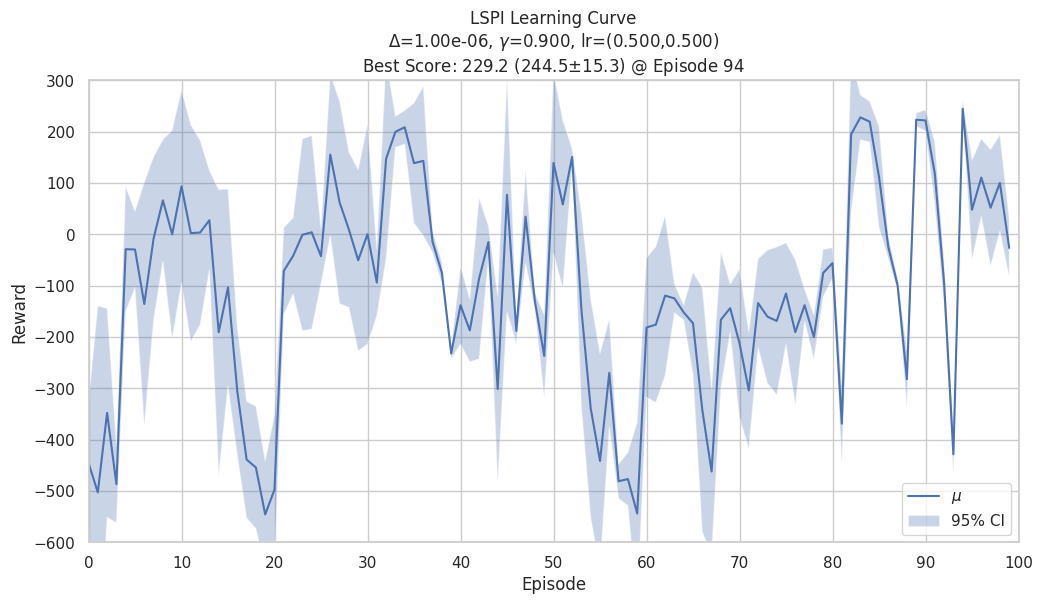

In [ ]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid") 
sns.lineplot(data=policies, x='episode', y='mean', label="$\mu$")
plt.fill_between( policies['episode'],
                  policies['mean'] - policies['halfwidth'],
                  policies['mean'] + policies['halfwidth'],
                  alpha=0.3,
                  label='95% CI')

policies.sort_values(by='score', ascending=False, inplace=True)
p = policies.iloc[0]

plt.title(f"LSPI Learning Curve\n" +\
          f"$\\Delta$={Δ:.2e}, $\\gamma$={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})\n" + \
          f"Best Score: {p['score']:.1f} ({p['mean']:.1f}$\\pm${p['halfwidth']:.1f}) @ Episode {p['episode']}" )
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.xlim(0, len(policies))
plt.ylim(-600, 300)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"learning_curve.pdf")

plt.show()

### Determine best policy ($w^*$)

In [17]:
best_score = -np.inf

print(f"EVALUATING TOP {num_best_policies} POLICES")
print("\t\tScore\t(μ ± δ)")
for i, p in policies.head(num_best_policies).iterrows():
    μ, δ = evaluate_policy(p['w'], num_evaluations=30, seed=1776)
    score = μ - δ
    print(f"Episode {i:3d}\t{score:.1f}\t({μ:.1f} ± {δ:.1f})")
    if ( best_score < score ):
        best_score = score
        w_star = p['w']
        m_star = p['episode']

print(f"SUPERLATIVE POLICY:\tEPISODE {m_star}")

EVALUATING TOP 10 POLICES
		Score	(μ ± δ)
Episode  94	155.8	(202.3 ± 46.5)
Episode  89	228.4	(238.9 ± 10.5)
Episode  90	199.7	(216.3 ± 16.6)
Episode  83	187.2	(210.9 ± 23.7)
Episode  84	186.0	(200.0 ± 13.9)
Episode  34	32.1	(105.5 ± 73.4)
Episode  33	104.8	(152.2 ± 47.3)
Episode  52	114.8	(138.1 ± 23.3)
Episode  91	86.8	(110.5 ± 23.7)
Episode  82	200.7	(224.9 ± 24.2)
SUPERLATIVE POLICY:	EPISODE 89


### The superlative policy $w^*$ weights

In [18]:
np.set_printoptions(precision=2)
print(f"w*:")
print( w_star.reshape(-1,4) )

w*:
[[ 2.24e-06 -1.66e-05  2.96e-06  3.51e-05]
 [ 1.28e-05  1.56e-05 -2.60e-06 -4.03e-06]
 [-3.88e-07 -2.69e-06  2.01e-06 -9.24e-08]
 [-9.45e-08  2.31e-06  1.19e-06  9.62e-06]
 [ 3.57e-07  5.27e-07 -3.85e-07  3.15e-07]
 [-4.03e-06  5.37e-06  2.70e-06 -6.24e-07]
 [ 3.17e-06 -2.60e-05 -2.90e-05  5.77e-06]
 [ 9.34e-06 -4.37e-05  1.07e-06 -3.09e-06]
 [ 1.07e-06 -3.09e-06  9.70e-07  6.72e-06]
 [-1.06e-05  1.35e-05  3.61e-05  1.89e-06]
 [ 1.46e-05 -1.38e-05 -5.40e-06  1.68e-06]
 [-4.57e-06 -2.83e-06 -8.05e-06  3.70e-06]
 [ 2.81e-07  8.91e-06  1.70e-05 -5.57e-06]
 [-7.15e-06  9.90e-08  1.90e-07 -1.83e-05]
 [ 5.30e-06 -3.77e-06  4.07e-06 -1.53e-06]
 [-1.42e-06 -1.06e-05  1.47e-05  2.13e-06]
 [-4.41e-05  8.74e-06  2.42e-08  8.74e-06]
 [ 2.42e-08 -5.65e-06  9.46e-06 -2.31e-05]
 [ 1.17e-05  1.87e-05  2.58e-06  4.51e-06]
 [-1.03e-05 -7.33e-06  3.61e-06 -7.63e-06]
 [ 3.13e-06 -1.02e-06  3.81e-06  2.99e-06]
 [ 8.36e-06 -5.05e-06 -2.18e-06 -1.61e-06]
 [ 7.88e-07  8.11e-07 -9.06e-06  3.69e-05]
 [ 1.49

### View video recording of the best policy

In [ ]:
title = f"LSPI Δ={Δ:.2e}, γ={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})"
video_filename = record_policy( w_star, title )
print(f"Done! Video saved to {video_filename}")

MoviePy - Building video best_policy_(219.3).mp4.
MoviePy - Writing video best_policy_(219.3).mp4



frame_index:  13%|█▎        | 541/4324 [00:07<00:54, 68.95it/s, now=None]

In [ ]:
Video(video_filename, embed=True)